## 1. Import dependency

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! unzip -qq "/content/drive/MyDrive/Mexican Sign Language Recognition-202205-DB.zip"

replace Mexican Sign Language Recognition/Testing/X_87_Datos.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Concatenate, Conv1D

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

## 2. Predefine


### 2.1 Plot loss curve

In [7]:

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

### 2.2 Create history class

In [8]:
class History:
  
  def __init__(self, history=None):
    self.history = {}
    self.create_history_object(history)

  def create_history_object(self, history):
    if history:
      for his in history.history.keys():
        self.history[his] = history.history[his]
  
  def add_history(self, history):
    if not self.history:
      self.create_history_object(history)
      return
    for his in history.history.keys():
      self.history[his] += history.history[his]

### 2.3. make_confusion_matrix

In [38]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False): 

    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] 
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

## 3. Get Class Names
* 3.1. ClassNames
* 3.2. Get ClassDict

### 3.1. get_className

In [10]:
def get_className(files_list):
    classNames = []
    for file in files_list:
        label = file.split("/")[-1].split("_")[0]
        if label not in classNames:
            classNames.append(label)
    classNames.sort()
    return classNames

### 3.2. get_classDict

In [11]:
def get_classDict(classNames):
    classDict = {}
    for index, className in enumerate(classNames):
        classDict[className] = index
    return classDict

## 4. Data load
* 4.1. load_data
* 4.2. get_dataFrame

### 4.1. load_data (data, label)

In [12]:
def load_data(filePath, classDict, totalClass):
    df = pd.read_csv(filePath).iloc[: ,1:].to_numpy()
    label = classDict[filePath.split("/")[-1].split("_")[0]]
    # label = tf.keras.utils.to_categorical(label, totalClass, dtype='int8')
    return df, label

### 4.2. get_dataFrame(dataFrame, labels)

In [13]:
def get_dataFrame(filesList, classDict, classNames):
    dataFrame = []
    labels = []
    for filePath in tqdm(filesList):
        data, label = load_data(filePath, classDict, len(classNames))
        dataFrame.append(data)
        labels.append(label)
    dataFrame = np.array(dataFrame)
    labels = np.array(labels)
    return dataFrame, labels

## 5. Data preprocessing
* 5.1. labels_oneHot_Encoding
* 5.2. preprocessing (shifting and scaling)

### 5.1. labels_oneHot_Encoding

In [14]:
def labels_oneHot_Encoding(labels, totalClasses):
    return tf.keras.utils.to_categorical(labels, totalClasses, dtype='int8')

## 6. Call all function and get file path
* 6.1. Csv files dir
* 6.2. Get all Files list
* 6.3. get classNames and classDict
* 6.4. get dataFrame and labels
* 6.5. data preprocessing
* 6.6. labels one hot
* 6.7. Data zip
* 6.8. Data shuffle
* 6.9. Data batch

### 6.1. Csv files dir

In [15]:
train_dir = "/content/Mexican Sign Language Recognition/TrainingValidation"
test_dir = "/content/Mexican Sign Language Recognition/Testing"

### 6.2. Get all files list

In [16]:
train_files = glob.glob(f"{train_dir}/*.csv")
test_files = glob.glob(f"{test_dir}/*.csv")

In [17]:
print(train_files)

['/content/Mexican Sign Language Recognition/TrainingValidation/Nombre_32_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/No_11_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/C_67_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Para que_5_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Martes_68_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Sabado_30_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Que es_6_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Si_65_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Que es_26_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/A_49_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Por que_64_Datos.csv', '/content/Mexican Sign Language Recognition/TrainingValidation/Domingo_24_Datos.c

### 6.3. get classNames and classDict

In [18]:
classNames = get_className(train_files)
classDict = get_classDict(classNames)

### 6.4. get dataFrame and labels

In [19]:
trainData, trainLabels =  get_dataFrame(train_files, classDict, classNames)

100%|██████████| 2550/2550 [00:27<00:00, 92.76it/s] 


In [20]:
testData, testLabels =  get_dataFrame(test_files, classDict, classNames)

100%|██████████| 450/450 [00:04<00:00, 108.88it/s]


In [21]:
trainData.shape, testData.shape, trainLabels.shape, testLabels.shape

((2550, 20, 201), (450, 20, 201), (2550,), (450,))

### 6.6. labels one hot

In [22]:
trainLabels = labels_oneHot_Encoding(trainLabels, len(classNames))
testLabels = labels_oneHot_Encoding(testLabels, len(classNames))

### 6.7. Data shuffle

In [23]:
trainData, trainLabels = shuffle(trainData, trainLabels, random_state=SEED)

## 7. Modeling

### 7.1. Creating checkpoint

In [24]:
checkpoint_path = f"CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

### 7.2. Create model

In [25]:
input_shape = trainData.shape[-2:]
input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

layer_1 = Conv1D(64, 3, activation='relu',padding='same')(input_layer)
layer_2 = Conv1D(64, 3, activation='relu', padding='same')(input_layer)

query_value_attention_seq = tf.keras.layers.Attention()(
    [layer_1, layer_2])

layer_3 = Conv1D(32, 10, activation='relu',padding='same')(layer_1)
layer_4 = Conv1D(128, 10, activation='relu',padding='same')(layer_3)

layer_5 = Conv1D(256, 10, activation='relu',padding='same')(layer_2)
layer_6 = Conv1D(128, 3, activation='relu',padding='same')(layer_5)

query_value_attention_seq_2 = tf.keras.layers.Attention()(
    [layer_4, layer_6])

concatinate_layer = Concatenate()([query_value_attention_seq, query_value_attention_seq_2])


# x = tf.keras.layers.Concatenate()([add_layer_1_2_gru, layer_5])

x = tf.keras.layers.Flatten()(concatinate_layer)


output_layer = tf.keras.layers.Dense(len(classNames), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(input_layer, output_layer)

### 7.3. Compile model

In [26]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 20, 201)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 64)       38656       ['input_layer[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 64)       38656       ['input_layer[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)              (None, 20, 32)       20512       ['conv1d[0][0]']                 
                                                                                              

### 7.4. Create history object

In [27]:
histories = History()

### 7.5. Fit model

In [28]:
history = model.fit(
    trainData,
    trainLabels,
    validation_data = (testData, testLabels),
    batch_size=32,
    epochs= 200,
    callbacks = checkpoint_callback
)
histories.add_history(history)

Epoch 1/200
80/80 [==============================] - 9s 80ms/step - loss: 2.5636 - accuracy: 0.1894 - val_loss: 1.9531 - val_accuracy: 0.3622
Epoch 2/200
80/80 [==============================] - 5s 66ms/step - loss: 1.4687 - accuracy: 0.4788 - val_loss: 1.8675 - val_accuracy: 0.4200
Epoch 3/200
80/80 [==============================] - 7s 91ms/step - loss: 1.0098 - accuracy: 0.6224 - val_loss: 1.5003 - val_accuracy: 0.5711
Epoch 4/200
80/80 [==============================] - 5s 64ms/step - loss: 0.9463 - accuracy: 0.6616 - val_loss: 1.3539 - val_accuracy: 0.6133
Epoch 5/200
80/80 [==============================] - 7s 87ms/step - loss: 0.7945 - accuracy: 0.7075 - val_loss: 1.1464 - val_accuracy: 0.6644
Epoch 6/200
80/80 [==============================] - 5s 68ms/step - loss: 0.6711 - accuracy: 0.7624 - val_loss: 1.1368 - val_accuracy: 0.6933
Epoch 7/200
80/80 [==============================] - 5s 63ms/step - loss: 0.6706 - accuracy: 0.7533 - val_loss: 1.4500 - val_accuracy: 0.5889
Epoch 

In [43]:
pd.DataFrame(history.history).to_csv("attention.csv",index=False)

### 7.6. Plot loss and accuracy

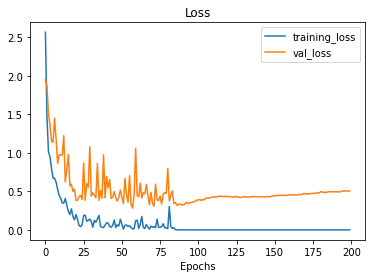

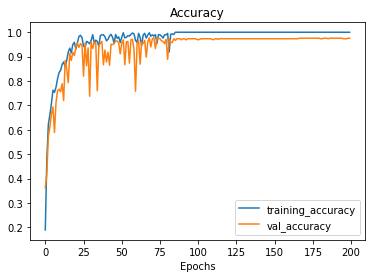

In [29]:
plot_loss_curves(histories)

## 8. Evaluate

### 8.1. Get best model

In [30]:
best_model = tf.keras.models.clone_model(model)

In [31]:
best_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
best_model.load_weights(checkpoint_path)

### 8.2. Evaluate

In [33]:
best_model.evaluate(trainData, trainLabels), best_model.evaluate(testData, testLabels)

15/15 [==============================] - 0s 15ms/step - loss: 0.3269 - accuracy: 0.9778


([0.013672730885446072, 0.9956862926483154],
 [0.3269173502922058, 0.9777777791023254])

### 8.3. Plot confusion_matrix

In [34]:
y_true = testLabels
y_pred = best_model.predict(testData)
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)
y_true.shape, y_pred.shape

15/15 [==============================] - 0s 14ms/step


((450,), (450,))

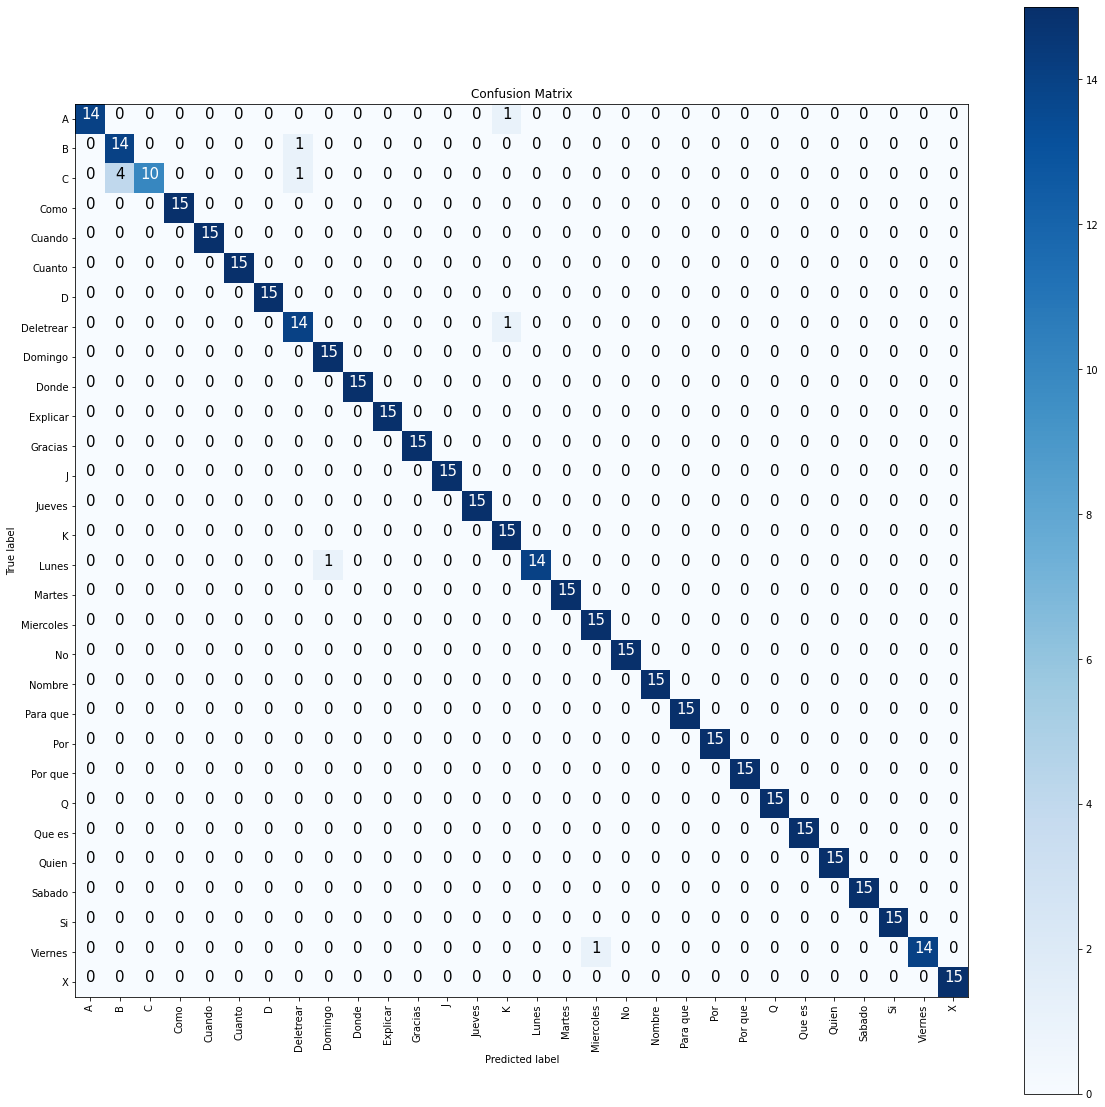

In [39]:
make_confusion_matrix(y_true, y_pred, classNames)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.78      0.93      0.85        15
           2       1.00      0.67      0.80        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       0.88      0.93      0.90        15
           8       0.94      1.00      0.97        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       0.88      1.00      0.94        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       0.94    